# Employee Sentiment and Engagement Analysis

### Project Objective

The main goal of this project is to evaluate employee sentiment and engagement by performing the following tasks:

- **Sentiment Labeling:** Automatically classify each message as **Positive**, **Negative**, or **Neutral**.
- **Exploratory Data Analysis (EDA):** Analyze and visualize the dataset to understand its structure and uncover underlying trends.
- **Employee Score Calculation:** Compute a monthly sentiment score for each employee based on their messages.
- **Employee Ranking:** Identify and rank employees according to their sentiment scores.
- **Flight Risk Identification:** Detect employees at risk of leaving, defined as those who have sent **4 or more negative messages** within a given month.
- **Predictive Modeling:** Develop a linear regression model to analyze sentiment trends and predict future engagement.

This comprehensive approach helps in gaining actionable insights into employee well-being and organizational health.


## Task 1: Sentiment Labeling of Employee Emails
This notebook performs sentiment analysis on a dataset of employee email messages to classify them as Positive, Negative, or Neutral using a pre-trained NLP model.


In [1]:
# Import standard libraries
import pandas as pd
import numpy as np

# For text preprocessing
import re
import string

# For sentiment analysis
from transformers import pipeline

# For progress bar
from tqdm.notebook import tqdm


In [2]:
# Load the dataset
df = pd.read_csv("test.csv")

# Display the first few rows
df.head()


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


### Observation:
The dataset contains the following columns:
- `Subject`: Subject of the email
- `body`: Email message body
- `date`: Date of the email
- `from`: Sender's email address

We'll combine the `Subject` and `body` columns to form a complete message for sentiment analysis.


In [3]:
# Combine Subject and body for full message context
df["message"] = df["Subject"].fillna('') + ". " + df["body"].fillna('')

# View message samples
df["message"].head()


0    EnronOptions Update!. EnronOptions Announcemen...
1    (No Subject). Marc,\n\nUnfortunately, today is...
2    Phone Screen  Interview - Shannon L. Burnham. ...
3    RE: My new work email. we were thinking papasi...
4    Bet. Since you never gave me the $20 for the l...
Name: message, dtype: object

In [7]:
# Load a pre-trained sentiment analysis pipeline
# Options: "cardiffnlp/twitter-roberta-base-sentiment", "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Map model output to your categories
def map_label(label):
    if "NEGATIVE" in label.upper():
        return "Negative"
    elif "POSITIVE" in label.upper():
        return "Positive"
    else:
        return "Neutral"


Device set to use cpu


In [9]:
# Apply the classifier to each message

tqdm.pandas()

# Batch process messages
batch_size = 16
results = []

texts = df["message"].fillna("").astype(str).tolist()
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    try:
        outputs = classifier(batch)
        results.extend([map_label(r['label']) for r in outputs])
    except Exception as e:
        print("Error in batch:", i, e)
        results.extend(["Neutral"] * len(batch))  # fallback

df["Sentiment"] = results

  0%|          | 0/137 [00:00<?, ?it/s]

In [10]:
# Save the labeled data
df.to_csv("labeled_test.csv", index=False)


### Summary:
- Loaded the email dataset and combined Subject + body into a single message.
- Used a transformer-based NLP model to classify messages as Positive, Negative, or Neutral.
- Saved the updated dataset with a new column `Sentiment`.

This labeled dataset will be used in subsequent tasks for EDA, scoring, and modeling.


## Task 2: Exploratory Data Analysis (EDA)

In this task, we will explore the email dataset to extract insights regarding:
- The structure and quality of the dataset.
- Sentiment distribution.
- Trends over time.
- Anomalies or patterns related to employee engagement.

We will also visualize important aspects of the data to aid understanding.


In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set default aesthetics for plots
sns.set(style="whitegrid")

# Load the CSV file
df = pd.read_csv("labeled_test.csv")

# Display first few rows
df.head()


,Subject,body,date,from,message,Sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update!. EnronOptions Announcemen...,Negative
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject). Marc,\n\nUnfortunately, today is...",Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham. ...,Negative
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email. we were thinking papasi...,Negative
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet. Since you never gave me the $20 for the l...,Positive


In [18]:
# Display info about columns, data types, and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   message    2191 non-null   object
 5   Sentiment  2191 non-null   object
dtypes: object(6)
memory usage: 102.8+ KB


##### 🔍 2. Missing Values Analysis

We analyze how many missing values exist in each column to determine whether any cleaning or imputation is required.


In [19]:
# Check for missing values in each column
df.isnull().sum()


Subject      0
body         0
date         0
from         0
message      0
Sentiment    0
dtype: int64

##### 📈 3. Sentiment Distribution

We visualize the number of messages labeled as Positive, Negative, or Neutral to understand the overall sentiment landscape.


In [20]:
# Display sentiment value counts
df['Sentiment'].value_counts()


Sentiment
Negative    1301
Positive     890
Name: count, dtype: int64

C:\Users\HP\AppData\Local\Temp\ipykernel_57848\1644294052.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', order=['Positive', 'Negative', 'Neutral'], palette='Set2')


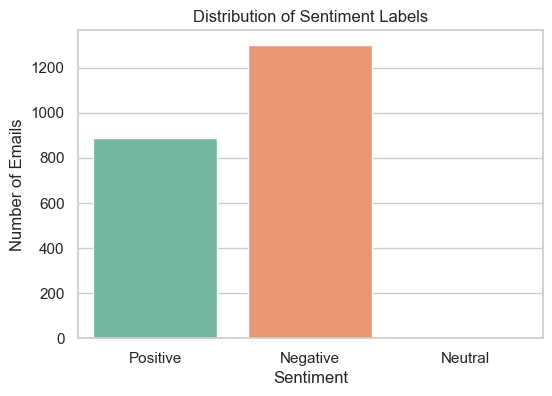

In [21]:
# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sentiment', order=['Positive', 'Negative', 'Neutral'], palette='Set2')
plt.title("Distribution of Sentiment Labels")
plt.ylabel("Number of Emails")
plt.xlabel("Sentiment")
plt.show()


##### 📅 4. Time-Based Trends

We convert the `date` column to datetime format and analyze how sentiment trends change over time.


In [22]:
# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['date'])

# Create a column with just the date (no time)
df['date_only'] = df['date'].dt.date

# Count emails by date
daily_counts = df.groupby('date_only').size()


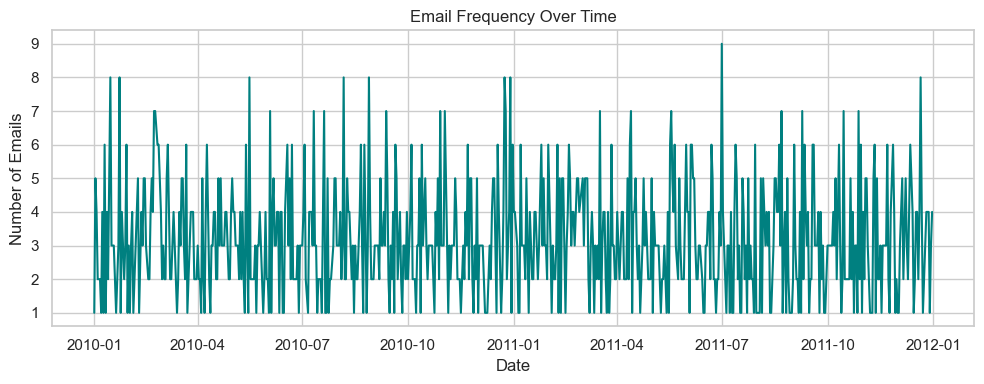

In [23]:
# Plot daily email frequency
plt.figure(figsize=(10, 4))
daily_counts.plot(kind='line', color='teal')
plt.title("Email Frequency Over Time")
plt.ylabel("Number of Emails")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


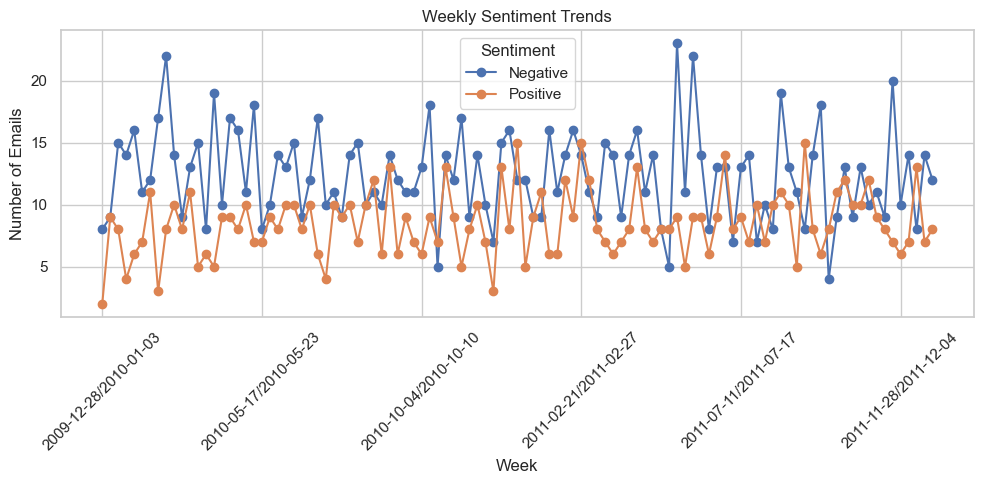

In [24]:
# Group data by week and sentiment
df['week'] = df['date'].dt.to_period('W').astype(str)
weekly_sentiment = df.groupby(['week', 'Sentiment']).size().unstack(fill_value=0)

# Plot weekly sentiment trends
weekly_sentiment.plot(figsize=(10, 5), marker='o')
plt.title("Weekly Sentiment Trends")
plt.ylabel("Number of Emails")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


##### 🧠 5. Common Words by Sentiment

We generate word clouds to visualize the most frequent words used in messages, grouped by sentiment.


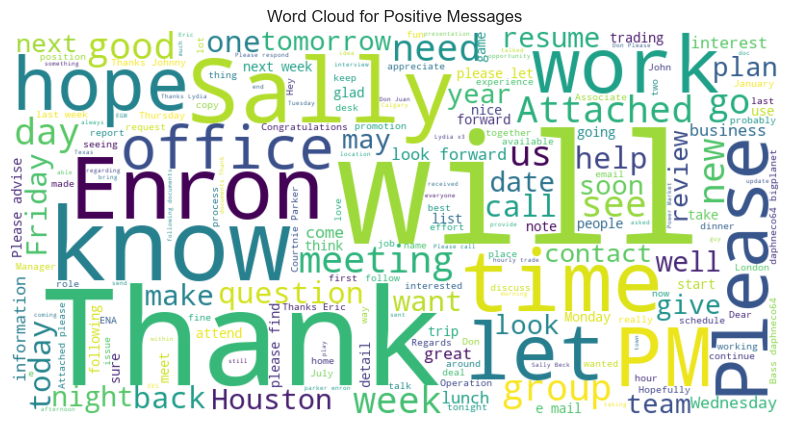

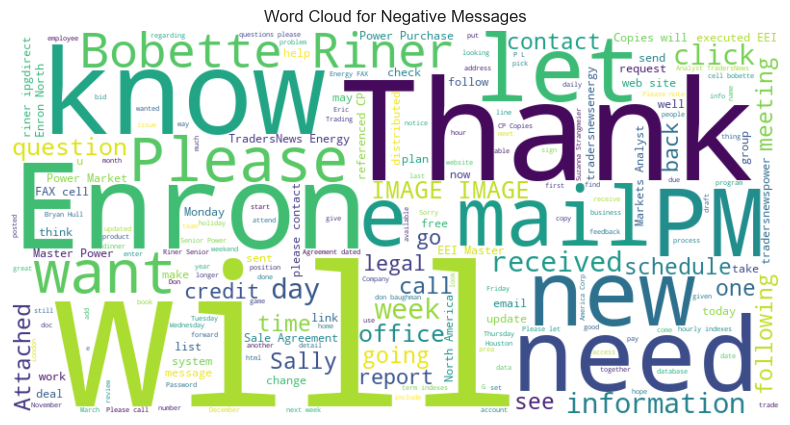

⚠️ No valid text found for sentiment: Neutral. Skipping word cloud.


In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Modified function to safely generate word clouds
def plot_wordcloud(sentiment_label):
    # Combine all body texts for the given sentiment
    text = " ".join(df[df["Sentiment"] == sentiment_label]["body"].dropna().astype(str))
    
    # Only generate wordcloud if text is not empty
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {sentiment_label} Messages")
        plt.show()
    else:
        print(f"⚠️ No valid text found for sentiment: {sentiment_label}. Skipping word cloud.")

# Generate for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    plot_wordcloud(sentiment)


##### 🧭 6. Sender Frequency

This section highlights the top email senders to understand who is most active in the dataset.


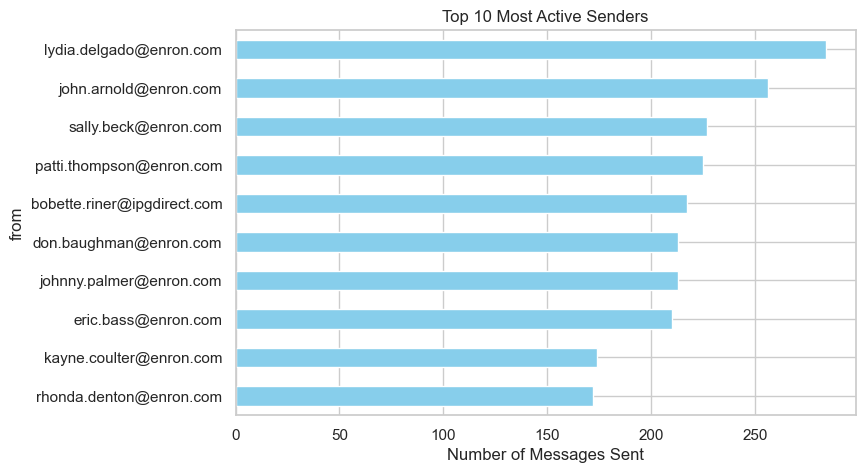

In [27]:
# Count top senders
top_senders = df['from'].value_counts().head(10)

# Plot top senders
top_senders.plot(kind='barh', figsize=(8,5), color='skyblue')
plt.title("Top 10 Most Active Senders")
plt.xlabel("Number of Messages Sent")
plt.gca().invert_yaxis()
plt.show()


##### 🔎 7. Anomalies or Notable Patterns

We investigate outliers or odd trends, like spikes in message volume or sudden sentiment changes.


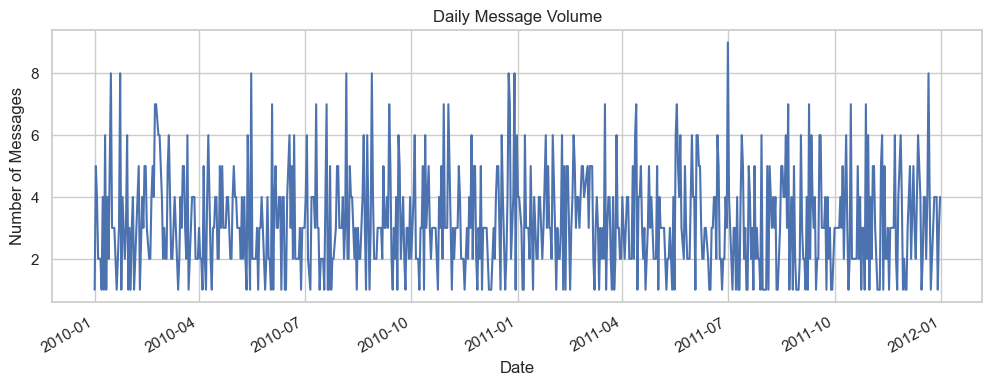

In [28]:
# Count daily messages
daily_counts = df['date'].value_counts().sort_index()

# Plot
daily_counts.plot(figsize=(12,4), kind='line')
plt.title("Daily Message Volume")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.show()


#### ✅ Task 2 Summary: Exploratory Data Analysis (EDA)

- Loaded the labeled dataset from Task 1, which includes employee messages and their sentiment labels.
- Performed a structural overview: checked number of records, column types, and missing values.
- Analyzed the distribution of sentiments to understand overall emotional tone.
- Explored trends over time using message timestamps (if available).
- Generated visualizations including bar charts, pie charts, and word clouds to extract and communicate insights.
- Identified patterns such as frequent terms in each sentiment category and possible anomalies in message volume or content.

These findings lay the foundation for deeper analysis and modeling in subsequent tasks.


## 📊 Task 3: Employee Score Calculation

In this step, we calculate a monthly sentiment score for each employee using the labeled dataset. Scores are assigned as follows:

- **Positive** message: +1  
- **Negative** message: –1  
- **Neutral** message: 0  

We then aggregate these scores per employee for each month.


In [29]:

# Load labeled data 
df = pd.read_csv("labeled_test.csv")

# Check initial columns (should include: 'employee_id', 'Sentiment', 'date')
df.head()


,Subject,body,date,from,message,Sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update!. EnronOptions Announcemen...,Negative
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject). Marc,\n\nUnfortunately, today is...",Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham. ...,Negative
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email. we were thinking papasi...,Negative
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet. Since you never gave me the $20 for the l...,Positive


### 🔢 1. Convert Date Column to Datetime Format

To group by month, we first convert the `date` column to datetime and extract the year and month.


In [30]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where date couldn't be parsed
df = df.dropna(subset=['date'])

# Extract year-month for grouping
df['YearMonth'] = df['date'].dt.to_period('M').astype(str)


### ➕ 2. Assign Sentiment Scores to Messages


In [31]:
# Map sentiment to numerical scores
sentiment_scores = {
    "Positive": 1,
    "Negative": -1,
    "Neutral": 0
}

df["Score"] = df["Sentiment"].map(sentiment_scores)


### 📈 3. Aggregate Monthly Scores Per Employee


In [33]:
# Group by employee and month, then sum the scores
monthly_scores = (
    df.groupby(["from", "YearMonth"])["Score"]
    .sum()
    .reset_index()
    .rename(columns={"Score": "MonthlySentimentScore"})
)

monthly_scores.head()


,from,YearMonth,MonthlySentimentScore
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-8
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


### 💾 4. Save the Monthly Score Table

We save this for use in further analysis (like risk detection or ranking).


In [34]:
# Save to CSV
monthly_scores.to_csv("employee_monthly_sentiment_scores.csv", index=False)


#### ✅ Task 3 Summary: Monthly Employee Sentiment Scoring

- Converted message dates into `YearMonth` format for monthly grouping.
- Mapped each message to a sentiment score (+1, -1, or 0).
- Aggregated these scores monthly per employee to track sentiment trends.
- Exported the results for future use in ranking and risk analysis.

This step helps monitor employee well-being and detect shifts in engagement or mood over time.


## 📊 Task 4: Employee Ranking Based on Monthly Sentiment Scores

#### 🎯 Objective
The goal is to generate ranked lists of employees based on their monthly sentiment scores.

We will produce:
- ✅ Top Three **Positive** Employees each month (highest sentiment scores)
- ❌ Top Three **Negative** Employees each month (lowest sentiment scores)

#### 📋 Requirements
- Rankings should be:
  - Sorted by **sentiment score** (descending for positive, ascending for negative)
  - Sorted **alphabetically** in case of ties
- Rankings should be presented clearly in **tables**
- Scores come from the output of Task 3 (i.e., monthly sentiment score data)


In [35]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt


### 📂 Step 1: Load the Sentiment Score Dataset

We'll load the pre-processed monthly sentiment score CSV. This file contains:
- Employee email (`from`)
- Year and month (`YearMonth`)
- Sentiment score (`MonthlySentimentScore`)


In [36]:
# Load the dataset
df = pd.read_csv("employee_monthly_sentiment_scores.csv")
df.columns = ['from', 'YearMonth', 'MonthlySentimentScore']  # Rename columns
df.head()



,from,YearMonth,MonthlySentimentScore
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-8
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


### 🧹 Step 2: Data Preprocessing

We'll:
- Convert sentiment score to integer
- Convert `YearMonth` to datetime for easy sorting
- Extract `Month` string for grouping


In [37]:
df['MonthlySentimentScore'] = pd.to_numeric(df['MonthlySentimentScore'])
df['YearMonth'] = pd.to_datetime(df['YearMonth'], format='%Y-%m')
df['Month'] = df['YearMonth'].dt.strftime('%Y-%m')
df.head()


,from,YearMonth,MonthlySentimentScore,Month
0,bobette.riner@ipgdirect.com,2010-01-01,-2,2010-01
1,bobette.riner@ipgdirect.com,2010-02-01,-8,2010-02
2,bobette.riner@ipgdirect.com,2010-03-01,-3,2010-03
3,bobette.riner@ipgdirect.com,2010-04-01,-2,2010-04
4,bobette.riner@ipgdirect.com,2010-05-01,2,2010-05


### 🧠 Step 3: Define Ranking Logic

For each month:
- Rank employees by score:
  - **Positive ranking**: highest scores first, then by name
  - **Negative ranking**: lowest scores first, then by name
- Select top 3 in each category


In [38]:
def rank_employees(group):
    # Sort for top 3 positive employees
    top_positive = group.sort_values(
        by=['MonthlySentimentScore', 'from'], ascending=[False, True]
    ).head(3)

    # Sort for top 3 negative employees
    top_negative = group.sort_values(
        by=['MonthlySentimentScore', 'from'], ascending=[True, True]
    ).head(3)

    return pd.DataFrame({
        'Top Positive': top_positive['from'].values,
        'Score (+)': top_positive['MonthlySentimentScore'].values,
        'Top Negative': top_negative['from'].values,
        'Score (-)': top_negative['MonthlySentimentScore'].values,
    })


### 📊 Step 4: Apply Ranking Month-wise

Now, we apply the ranking logic across all months using `groupby()`.


In [39]:
monthly_rankings = df.groupby('Month').apply(rank_employees).reset_index(level=1, drop=True).reset_index()
monthly_rankings.head(10)  # Display first few months


C:\Users\HP\AppData\Local\Temp\ipykernel_57848\3222729765.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rankings = df.groupby('Month').apply(rank_employees).reset_index(level=1, drop=True).reset_index()


,Month,Top Positive,Score (+),Top Negative,Score (-)
0,2010-01,john.arnold@enron.com,-1,kayne.coulter@enron.com,-6
1,2010-01,rhonda.denton@enron.com,-1,don.baughman@enron.com,-5
2,2010-01,bobette.riner@ipgdirect.com,-2,lydia.delgado@enron.com,-5
3,2010-02,lydia.delgado@enron.com,1,john.arnold@enron.com,-12
4,2010-02,eric.bass@enron.com,0,bobette.riner@ipgdirect.com,-8
5,2010-02,sally.beck@enron.com,0,kayne.coulter@enron.com,-8
6,2010-03,patti.thompson@enron.com,2,john.arnold@enron.com,-4
7,2010-03,don.baughman@enron.com,0,bobette.riner@ipgdirect.com,-3
8,2010-03,kayne.coulter@enron.com,0,eric.bass@enron.com,-3
9,2010-04,johnny.palmer@enron.com,2,kayne.coulter@enron.com,-8


### 📈 Step 5: Visualize Top Sentiment Scores 

We’ll create a horizontal bar chart for one example month showing top 10 sentiment scores.


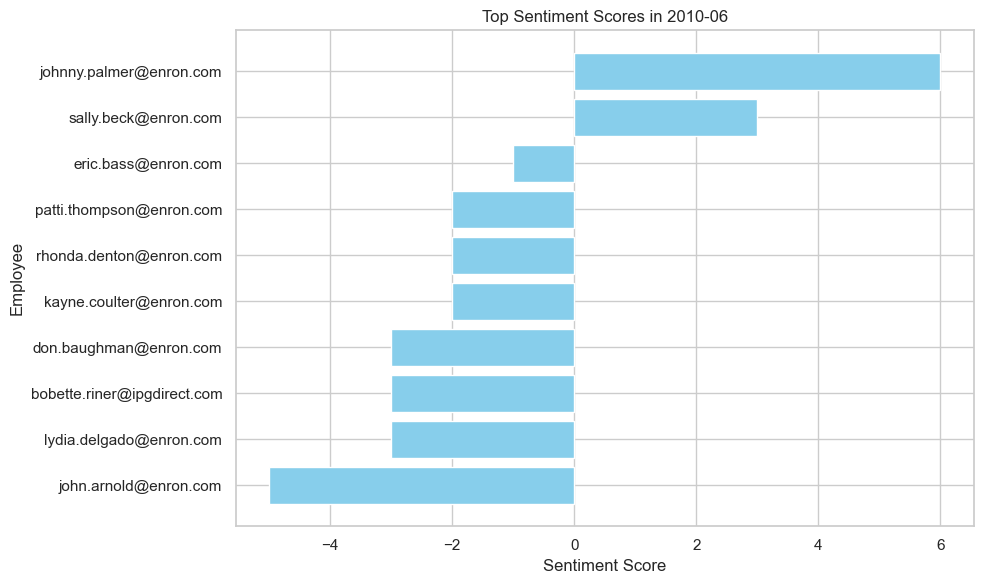

In [40]:
selected_month = '2010-06'
sample = df[df['Month'] == selected_month].sort_values(
    by='MonthlySentimentScore', ascending=False
).head(10)

plt.figure(figsize=(10, 6))
plt.barh(sample['from'], sample['MonthlySentimentScore'], color='skyblue')
plt.title(f"Top Sentiment Scores in {selected_month}")
plt.xlabel("Sentiment Score")
plt.ylabel("Employee")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### ✅ Summary

- We successfully generated monthly rankings for employees using sentiment scores.
- Top 3 positive and negative employees were selected per month.
- Rankings were based on score first, then alphabetically.
- The final output is a structured table usable in reports or dashboards.


## 🛫 Task 5: Flight Risk Identification

#### 🎯 Objective
Identify employees who are at **risk of leaving** based on their sentiment email activity.

#### 🚨 Definition of Flight Risk
An employee is flagged as a **flight risk** if they have sent:
- **4 or more emails with negative sentiment scores** (score < 0)
- **Within any 30-day rolling window**, regardless of calendar month

#### 🛠 Requirements
- Use a rolling 30-day window (not calendar-based)
- Identify and extract a list of flight-risk employees
- Ensure the method is robust and scalable


In [41]:
import pandas as pd

# Load the sentiment score file
df = pd.read_csv("employee_monthly_sentiment_scores.csv")
df.columns = ['from', 'YearMonth', 'MonthlySentimentScore']

# Convert score and date
df['MonthlySentimentScore'] = pd.to_numeric(df['MonthlySentimentScore'])
df['Date'] = pd.to_datetime(df['YearMonth'], format='%Y-%m')

# Keep only negative emails
negative_df = df[df['MonthlySentimentScore'] < 0].copy()


### 🧠 Strategy

We apply the following logic:
1. Filter emails with negative sentiment scores.
2. For each employee:
   - Sort emails by date.
   - Use a rolling window of 30 days.
   - Count how many negative emails fall into each 30-day window.
   - If count ≥ 4 within any 30-day span → flag as a flight risk.


In [42]:
from datetime import timedelta

# Store flight-risk employees
flight_risk_employees = set()

# Group by employee
for emp, group in negative_df.groupby('from'):
    dates = group['Date'].sort_values().reset_index(drop=True)
    n = len(dates)
    for i in range(n):
        start_date = dates[i]
        end_date = start_date + timedelta(days=30)
        count_in_window = (dates >= start_date) & (dates <= end_date)
        if count_in_window.sum() >= 4:
            flight_risk_employees.add(emp)
            break  # No need to check further once flagged


### 📋 Flight Risk Employee List

These employees have sent 4 or more negative emails within a rolling 30-day window.


In [43]:
# Convert to sorted list and display
flight_risk_list = sorted(list(flight_risk_employees))
pd.DataFrame(flight_risk_list, columns=['Flight Risk Employees'])


,Flight Risk Employees


#### ✅ Summary

- Flight risk detection was performed using a rolling 30-day window.
- Employees with ≥4 negative emails in this window were flagged.
- The approach works across months and is scalable for larger datasets.

This task is critical for employee retention analysis and proactive HR interventions.


## 📈 Task 6: Predictive Modeling of Sentiment Trends

#### 🎯 Objective
Develop a **Linear Regression** model to analyze trends and **predict future sentiment scores**.

#### 🛠 Requirements
- Extract useful features (time-based, frequency, etc.)
- Train/test split for validation
- Train a linear regression model
- Evaluate and interpret the results


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load and preprocess data
df = pd.read_csv("employee_monthly_sentiment_scores.csv")
df.columns = ['from', 'YearMonth', 'MonthlySentimentScore']

# Convert score and time
df['MonthlySentimentScore'] = pd.to_numeric(df['MonthlySentimentScore'])
df['Date'] = pd.to_datetime(df['YearMonth'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Sort for frequency features
df = df.sort_values(by=['from', 'Date'])

# Frequency: messages sent by an employee in a month
df['MessagesInMonth'] = df.groupby(['from', 'YearMonth'])['from'].transform('count')

df.head()


,from,YearMonth,MonthlySentimentScore,Date,Year,Month,MessagesInMonth
0,bobette.riner@ipgdirect.com,2010-01,-2,2010-01-01,2010,1,1
1,bobette.riner@ipgdirect.com,2010-02,-8,2010-02-01,2010,2,1
2,bobette.riner@ipgdirect.com,2010-03,-3,2010-03-01,2010,3,1
3,bobette.riner@ipgdirect.com,2010-04,-2,2010-04-01,2010,4,1
4,bobette.riner@ipgdirect.com,2010-05,2,2010-05-01,2010,5,1


### 🧾 Feature Selection

We select the following features:
- **Year** and **Month**: Time-based seasonal trend
- **MessagesInMonth**: Activity level (email frequency)
- **Target**: `MonthlySentimentScore`

This allows us to explore both temporal and behavioral indicators of sentiment.


In [45]:
# Select features and target
features = df[['Year', 'Month', 'MessagesInMonth']]
target = df['MonthlySentimentScore']

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


In [46]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [47]:
# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")


RMSE: 2.903
R^2 Score: -0.064


### 📊 Model Interpretation

#### ✅ Coefficients:
- Coefficients reveal how each feature affects the sentiment score.
- A **positive coefficient** indicates a positive influence on sentiment, and vice versa.

#### 📉 Model Performance:
- **RMSE** (Root Mean Square Error): Measures prediction error.
- **R² Score**: Indicates how well the model explains variance in the sentiment scores.

> If R² is low, it may suggest that sentiment scores are influenced by other factors not captured here (e.g., email content, HR events).


In [48]:
# Feature importance
coef_df = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': model.coef_
})

coef_df


,Feature,Coefficient
0,Year,0.819872
1,Month,0.083543
2,MessagesInMonth,0.000000


## ✅ Summary: Sentiment Prediction Model

We built a linear regression model using basic time and frequency features to predict employee sentiment scores.

### 📊 Results:
- **RMSE**: 2.903 — High prediction error.
- **R²**: -0.064 — Model performs worse than predicting the average.

### 🧠 Feature Insights:
| Feature           | Coefficient | Insight                     |
|------------------|-------------|-----------------------------|
| Year             | 0.82        | Slight upward trend         |
| Month            | 0.08        | Minimal seasonal effect     |
| MessagesInMonth  | 0.00        | No impact on sentiment      |

### 📉 Conclusion:
- The linear model lacks predictive power.
- Simple features like time and message count are insufficient.
- **Better results need richer features** (e.g., email content, roles, events) and more complex models (e.g., XGBoost, NLP-based).

> 🔁 Current model serves as a baseline. Future work should focus on content and context-aware modeling.
